# Influence of the sampling frequency on the DMD spectrum

In [1]:
from os.path import join
from os import makedirs
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from flowtorch.analysis import DMD
from utils import normalize_frequency, add_oat_patch

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "/home/andre/Development/naca0012_shock_buffet/run/oat15"
path = "./output/oat15_analysis/dmd_sampling_frequency"

makedirs(path, exist_ok=True)

In [2]:
CHORD = 0.15
U_INF = 238.59

times = pt.load(join(data, "oat15_tandem_times.pt"))[::10]
vertices = pt.load(join(data, "vertices_and_masks.pt"))
area = vertices["area_small"]
weight = area.sqrt().unsqueeze(-1)
x = vertices["x_small"] / CHORD
z = vertices["z_small"] / CHORD
del vertices
start_at, end_at = 101, 501 # encloses 2 cycles
dt = times[1] - times[0]

In [3]:
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at]
dm = pt.cat((vel_x, vel_z)) * weight.repeat((2, 1))
del vel_x, vel_z

In [8]:
dmd_spectra = {}
for every in [1, 2, 4, 8, 16, 32, 64]:
    print(f"\rUsing every {every} snapshot", end="")
    dmd = DMD(dm[:, ::every], dt*every, rank=65, optimal=True)
    dmd_spectra[every] = (dmd.frequency, dmd.integral_contribution, dmd.svd.opt_rank)

Using every 64 snapshot

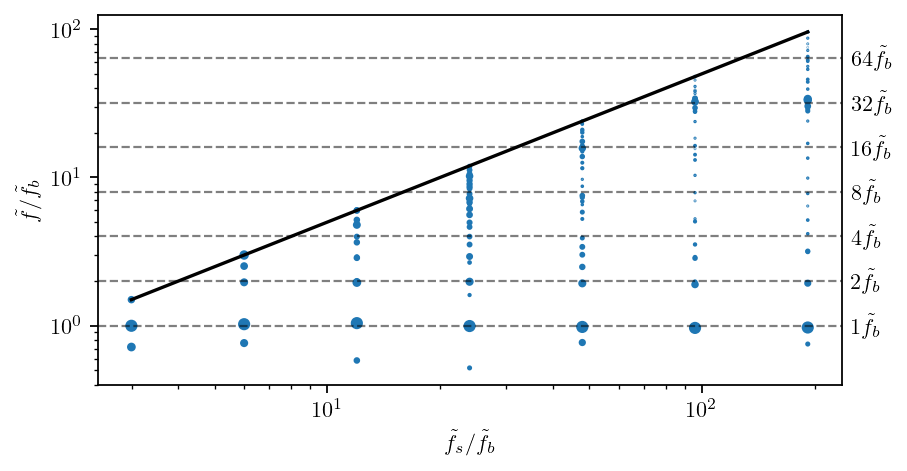

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

fb = 118.5

for every in [1, 2, 4, 8, 16, 32, 64]:
    fs = 1.0 / (dt*every)
    f_ratio = fs / fb
    f_norm = dmd_spectra[every][0]/fb
    f_pos = f_norm > 0.001
    f_norm = f_norm[f_pos]
    imp = dmd_spectra[every][1][f_pos]
    imp /= imp.max()
    ax.scatter(pt.ones(f_norm.shape[0])*f_ratio, f_norm, s=imp*20, c="C0")
    
fs = pt.tensor([1.0 / (dt*every) for every in [1, 2, 4, 8, 16, 32, 64]])
ax.plot(fs/fb, 0.5*fs/fb, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
for every in [1, 2, 4, 8, 16, 32, 64]:
    ax.axhline(every, ls="--", lw=1, c="k", alpha=0.5)
    ax.text(250, every, r"${:d}\tilde{{f}}_b$".format(every), va="center")
ax.set_xlabel(r"$\tilde{f}_s/\tilde{f}_b$")
ax.set_ylabel(r"$\tilde{f}/\tilde{f}_b$")
plt.savefig(join(path, "fs_dependency.pdf"), bbox_inches="tight")
plt.show()

In [10]:
dmd_spectra = {}
for every in [1, 2, 4, 8, 16, 32, 64]:
    print(f"\rUsing every {every} snapshot", end="")
    dmd = DMD(dm[:, ::every], dt*every, rank=65, optimal=True, tlsq=True)
    dmd_spectra[every] = (dmd.frequency, dmd.integral_contribution, dmd.svd.opt_rank)

Using every 64 snapshot

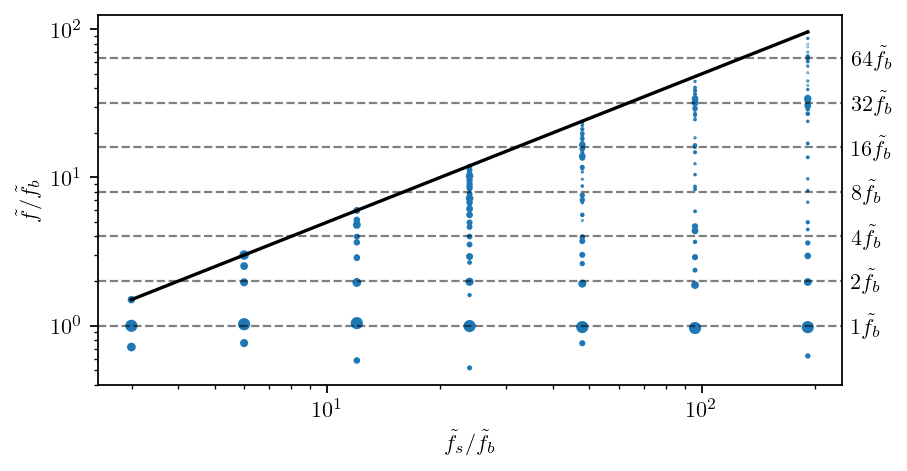

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))

fb = 118.5

for every in [1, 2, 4, 8, 16, 32, 64]:
    fs = 1.0 / (dt*every)
    f_ratio = fs / fb
    f_norm = dmd_spectra[every][0]/fb
    f_pos = f_norm > 0.001
    f_norm = f_norm[f_pos]
    imp = dmd_spectra[every][1][f_pos]
    imp /= imp.max()
    ax.scatter(pt.ones(f_norm.shape[0])*f_ratio, f_norm, s=imp*20, c="C0")
    
fs = pt.tensor([1.0 / (dt*every) for every in [1, 2, 4, 8, 16, 32, 64]])
ax.plot(fs/fb, 0.5*fs/fb, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
for every in [1, 2, 4, 8, 16, 32, 64]:
    ax.axhline(every, ls="--", lw=1, c="k", alpha=0.5)
    ax.text(250, every, r"${:d}\tilde{{f}}_b$".format(every), va="center")
ax.set_xlabel(r"$\tilde{f}_s/\tilde{f}_b$")
ax.set_ylabel(r"$\tilde{f}/\tilde{f}_b$")
plt.savefig(join(path, "fs_dependency_TDMD.pdf"), bbox_inches="tight")
plt.show()

In [10]:
fs/fb*0.5

tensor([95.9051, 47.9525, 23.9763, 11.9881,  5.9941,  2.9970,  1.4985])

In [7]:
dmd_e2 = DMD(dm[:, ::2], dt*2, rank=65, optimal=True)
dmd_e4 = DMD(dm[:, ::4], dt*4, rank=65, optimal=True)

In [8]:
def add_mode_symmetric(ax, mode, n_levels=60):
    vmin, vmax = mode.min(), mode.max()
    vmax = max(vmin.abs(), vmax.abs())
    vmin = -vmax
    levels = pt.linspace(vmin, vmax, n_levels)
    ax.tricontourf(x, z, mode, levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")

In [ ]:
n_modes = 2
n_points = weight.shape[0]
top_e2 = (dmd_e2.top_modes(1, integral=True, f_min=0.001)[0], dmd_e2.top_modes(1, integral=True, f_min=500)[0])
top_e4 = (dmd_e4.top_modes(1, integral=True, f_min=0.001)[0], dmd_e4.top_modes(1, integral=True, f_min=500)[0])
fig, axarr = plt.subplots(n_modes, 2, figsize=(6, 1*n_modes), sharex=True, sharey=True)

for i, (mi2, mi4) in enumerate(zip(top_e2, top_e4)):
    add_mode_symmetric(axarr[0, i], dmd_e2.modes[:n_points, mi2].real/weight.squeeze(), 100)
    add_mode_symmetric(axarr[1, i], dmd_e4.modes[:n_points, mi4].real/weight.squeeze(), 100)
    axarr[0, i].set_title(r"$\Re (u_x)$" + r", $\tilde{f} = " + "{:2.2f}$".format(normalize_frequency(dmd_e2.frequency[mi2], CHORD, U_INF)))
    axarr[1, i].set_title(r"$\Re (u_x)$" + r", $\tilde{f} = " + "{:2.2f}$".format(normalize_frequency(dmd_e4.frequency[mi4], CHORD, U_INF)))
    for ax in axarr.flatten():
        ax.set_aspect("equal")
        add_oat_patch(ax)
        ax.set_ylim(-0.2, 0.5)
        ax.set_xlim(-0.1, 2.5)

for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\tilde{x}$")
    
axarr[0, 1].text(2.6, -0.2, r"$\tilde{f}_s/\tilde{f}_b\approx 96$", rotation=90)
axarr[1, 1].text(2.6, -0.2, r"$\tilde{f}_s/\tilde{f}_b\approx 48$", rotation=90)
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel(r"$\tilde{z}$")
plt.savefig(join(path, "fs_influence_modes.png"), bbox_inches="tight")
plt.show()